---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv
import time

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [3]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [4]:
# Task 2a: Load the data

products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Number of products: {len(products)}")
print(f"Number of queries: {len(queries)}")
print(f"Number of labels: {len(labels)}")



Number of products: 42994
Number of queries: 480
Number of labels: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [5]:
#print columns
print(products.columns)

#display sample products
products.head()


Index(['product_id', 'product_name', 'product_class', 'category_hierarchy',
       'product_description', 'product_features', 'rating_count',
       'average_rating', 'review_count'],
      dtype='str')


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [6]:
#print columns
print(labels.columns)

#display sample products
labels.head()

Index(['id', 'query_id', 'product_id', 'label', 'grade'], dtype='str')


,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2
1,1,0,12088,Irrelevant,0
2,2,0,42931,Exact,2
3,3,0,2636,Exact,2
4,4,0,42923,Exact,2


In [7]:
#print columns
print(queries.columns)

#display sample products
queries.head()

Index(['query_id', 'query', 'query_class'], dtype='str')


,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [8]:
# Task 2c: Understand judgments

grade_counts = labels['grade'].value_counts().sort_index()
print("Grade distribution:")
print(grade_counts)



Grade distribution:
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [9]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [10]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [11]:
# Task 3a: Create BM25 index for product_name


product_name_docs = products['product_name'].tolist()
product_name_index, product_name_lengths = build_index(product_name_docs, snowball_tokenize)
avg_product_name_length = sum(product_name_lengths) / len(product_name_lengths)
print("BM25 index for product_name built")


BM25 index for product_name built


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [12]:
# Task 3b: Add product_description to search

# Build BM25 index for product_description
product_description_docs = products['product_description'].tolist()
product_description_index, product_description_lengths = build_index(product_description_docs, snowball_tokenize)
avg_product_description_length = sum(product_description_lengths) / len(product_description_lengths)
print("BM25 index for product_description built")

# Function to combine BM25 scores from product_name and product_description
def combined_bm25_search(query, top_k=10):
    # Score product_name
    product_name_scores = score_bm25(
        query,
        product_name_index,
        product_name_lengths,
        avg_product_name_length,
        snowball_tokenize
    )
    # Score product_description
    product_description_scores = score_bm25(
        query,
        product_description_index,
        product_description_lengths,
        avg_product_description_length,
        snowball_tokenize
    )
    # Combine the scores by adding
    combined_scores = {}
    for doc_id in set(product_name_scores) | set(product_description_scores):
        combined_scores[doc_id] = product_name_scores.get(doc_id, 0) + product_description_scores.get(doc_id, 0)
    # Sort by combined scores highest first
    ranked_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_results[:top_k]

print("Combined multi-field BM25 search function creation complete")


BM25 index for product_description built
Combined multi-field BM25 search function creation complete


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [13]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
# DCG uses log2 for the discount because it gives more weight to results at the top of the list.
# The effect on position 1 vs position 10 is that position 1 has no discount, while position 10 has a larger discount.



### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [14]:

# Task 4b: Calculate NDCG by hand

# DCG = 4.5
# NDCG = 0.78
    

### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [15]:
# Task 4c: Implement NDCG function

def calculate_dcg(relevances: list[int], k: int) -> float:
    dcg = 0
    for i, relevance in enumerate(relevances[:k]):
        dcg += (2**relevance - 1) / np.log2(i + 2)
    return dcg

def calculate_ndcg(relevances: list[int], k: int) -> float:
    dcg = calculate_dcg(relevances, k)
    ideal_dcg = calculate_dcg(sorted(relevances, reverse=True), k)
    if ideal_dcg == 0:
        return 0.0
    return dcg / ideal_dcg

In [16]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [17]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [18]:
# Task 5a: Run evaluation on all queries


# Returns top k products with product_name containing any keyword from query
def baseline_search(query, products, k=20):
    terms = query.lower().split()
    mask = products['product_name'].str.lower().apply(lambda x: any(term in x for term in terms))
    hits = products[mask]
    # Fallback
    if hits.empty:
        hits = products.sort_values('rating_count', ascending=False).head(k)
    else:
        hits = hits.head(k)
    return hits[['product_id']]

def search_func(query):
    return baseline_search(query, products, k=20)

# Run evaluation using the evaluation function defined earlier
eval_results_df = evaluate_search(search_func, products, queries, labels, k=5, verbose=True)

# Show head of results
display(eval_results_df.head())
eval_results_df.head()

print("works")





Evaluated 480 queries
Mean NDCG@5: 0.3582


,query_id,query,ndcg
0,0,salon chair,0.760640
1,1,smart coffee table,1.000000
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.386853
4,4,chair and a half recliner,0.000000


works


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [19]:
# Task 5b: Identify failing queries

# Find queries with NDCG <= 0.1 
failing_queries = eval_results_df[eval_results_df['ndcg'] <= 0.1]
print("Failing queries (NDCG <= 0.1):")
display(failing_queries.merge(queries, on='query_id').head())

if not failing_queries.empty:
    # Analyze the first failing query
    fail_row = failing_queries.iloc[0]
    qid = fail_row['query_id']
    ndcg_val = fail_row['ndcg']
    query_text = queries.loc[queries['query_id'] == qid, 'query'].values[0]
    print(f"Analyzing query_id={qid}, query='{query_text}' (NDCG={ndcg_val:.3f})")
    
    # Show results returned by the baseline search
    hits = baseline_search(query_text, products, k=5)
    print("Top 5 baseline search product_ids:")
    print(hits['product_id'].tolist())

    # Show relevant labels for this query
    relevant = labels[labels['query_id'] == qid]
    print("Relevant judgments for this query (grade>0):")
    display(relevant[relevant['grade'] > 0].merge(products, left_on='product_id', right_on='product_id')[['product_id','label','grade','product_name']])



Failing queries (NDCG <= 0.1):


,query_id,query_x,ndcg,query_y,query_class
0,4,chair and a half recliner,0.0,chair and a half recliner,Recliners
1,6,acrylic clear chair,0.0,acrylic clear chair,Dining Chairs
2,8,home sweet home sign,0.0,home sweet home sign,Wall Décor
3,12,large spoon and fork wall decor,0.0,large spoon and fork wall decor,Wall Décor
4,13,outdoor privacy wall,0.0,outdoor privacy wall,Fencing & Accessories


Analyzing query_id=4, query='chair and a half recliner' (NDCG=0.000)
Top 5 baseline search product_ids:
[0, 1, 2, 3, 4]
Relevant judgments for this query (grade>0):


,product_id,label,grade,product_name
0,10957,Partial,1,aeneas 33 '' wide faux leather manual standard...
1,24866,Partial,1,aindriu 31.2 '' wide velvet manual home theate...
2,24867,Partial,1,ainhoa 36.6 '' wide manual standard recliner
3,24869,Partial,1,ainikki 38.2 '' wide velvet manual home theate...
4,5488,Exact,2,ajete 42 '' wide manual standard recliner
...,...,...,...,...
186,24147,Partial,1,power recliner and lift chair in black pu leat...
187,10738,Partial,1,keleigh 34.5 '' wide genuine leather manual wi...
188,42405,Partial,1,reclining massage chair with ottoman
189,7444,Partial,1,faux leather reclining massage chair


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

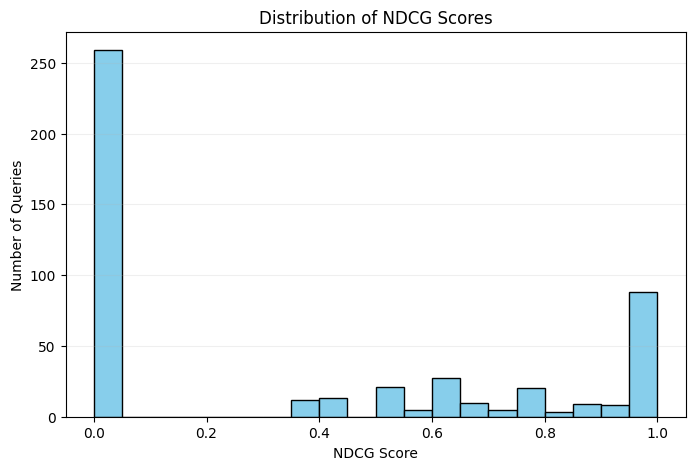

NDCG mean: 0.358
NDCG median: 0.000


In [20]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(eval_results_df['ndcg'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NDCG Scores')
plt.xlabel('NDCG Score')
plt.ylabel('Number of Queries')
plt.grid(axis='y', alpha=0.2)
plt.show()

print(f"NDCG mean: {eval_results_df['ndcg'].mean():.3f}")
print(f"NDCG median: {eval_results_df['ndcg'].median():.3f}")



---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [21]:
# Task 6a: Index product_class field

def search_products_three_fields(query, products_df):
    """
    Search across three fields: product_name, product_description, and product_class.
    For each field, check if any query term appears in the field and sum the scores.
    """
    terms = query.lower().split()
    
    def compute_score(row):
        # Check each term in product_name
        name_score = sum(1 for term in terms if term in str(row["product_name"]).lower())
        # Check each term in product_description
        desc_score = sum(1 for term in terms if term in str(row["product_description"]).lower())
        # Check each term in product_class
        class_score = sum(1 for term in terms if term in str(row["product_class"]).lower())
        
        # Weighted sum - boost product_name and product_class more than description
        total = (name_score * 3) + (class_score * 2) + desc_score
        return total

    products_df = products_df.copy()
    products_df["search_score"] = products_df.apply(compute_score, axis=1)
    results = products_df.sort_values("search_score", ascending=False)
    results = results[results["search_score"] > 0]
    
    # If no results, fallback to popular products
    if results.empty:
        results = products_df.sort_values('rating_count', ascending=False)
    
    return results




### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [22]:
# Task 6b: Evaluate three-field search

def three_field_search_func(query):
    results = search_products_three_fields(query, products)
    return results[['product_id']].head(20)

# Run evaluation on the three-field search
eval_results_three_field = evaluate_search(three_field_search_func, products, queries, labels, k=5, verbose=True)

# Show head of results
print("\nThree-field search results:")
display(eval_results_three_field.head(10))

# Compare to baseline
print(f"\nBaseline Mean NDCG@5: {eval_results_df['ndcg'].mean():.4f}")
print(f"Three-field Mean NDCG@5: {eval_results_three_field['ndcg'].mean():.4f}")
print(f"Improvement: {eval_results_three_field['ndcg'].mean() - eval_results_df['ndcg'].mean():.4f}")


Evaluated 480 queries
Mean NDCG@5: 0.8668

Three-field search results:


,query_id,query,ndcg
0,0,salon chair,0.848074
1,1,smart coffee table,1.000000
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.989141
4,4,chair and a half recliner,1.000000
5,5,sofa with ottoman,1.000000
6,6,acrylic clear chair,0.955830
7,7,driftwood mirror,0.980771
8,8,home sweet home sign,0.989141
9,9,coffee table fire pit,1.000000



Baseline Mean NDCG@5: 0.3582
Three-field Mean NDCG@5: 0.8668
Improvement: 0.5086


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [23]:
# Task 6c: Compare to baseline

# Compare NDCG@5 between baseline and three-field search for each query
comparison = eval_results_df[['query_id', 'ndcg']].merge(
    eval_results_three_field[['query_id', 'ndcg']], 
    on='query_id', 
    how='inner', 
    suffixes=('_baseline', '_threefield')
)
comparison['delta'] = comparison['ndcg_threefield'] - comparison['ndcg_baseline']

# Queries that improved
improved = comparison[comparison['delta'] > 0]
print(f"Queries improved: {len(improved)}")
display(queries.merge(improved, on="query_id")[['query_id','query','ndcg_baseline','ndcg_threefield','delta']].sort_values("delta", ascending=False).head(10))

# Queries that degraded
degraded = comparison[comparison['delta'] < 0]
print(f"Queries degraded: {len(degraded)}")
display(queries.merge(degraded, on="query_id")[['query_id','query','ndcg_baseline','ndcg_threefield','delta']].sort_values("delta").head(10))




Queries improved: 353


,query_id,query,ndcg_baseline,ndcg_threefield,delta
352,486,54 in bench cushion,0.0,1.0,1.0
181,250,multi color rug,0.0,1.0,1.0
148,205,ines shag rug w003096809,0.0,1.0,1.0
149,206,grill cover 73,0.0,1.0,1.0
151,211,memory foam rug galveston,0.0,1.0,1.0
154,214,light wood nightstand with silver accents,0.0,1.0,1.0
156,216,music plug wall plate,0.0,1.0,1.0
157,219,trinaic towel rod,0.0,1.0,1.0
159,221,small space dining table and chairs sets,0.0,1.0,1.0
162,226,power lift chair,0.0,1.0,1.0


Queries degraded: 37


,query_id,query,ndcg_baseline,ndcg_threefield,delta
36,487,rack glass,1.000000,0.000000,-1.000000
33,475,rattan truck,1.000000,0.000000,-1.000000
27,386,alter furniture,1.000000,0.000000,-1.000000
26,385,mom urn,1.000000,0.000000,-1.000000
13,227,owl,0.852928,0.000000,-0.852928
22,356,platform bed side table,1.000000,0.500000,-0.500000
28,395,pantry grey,0.430677,0.000000,-0.430677
31,441,desk for kids,0.760640,0.386853,-0.373787
16,278,parakeet toy,0.946493,0.618289,-0.328205
29,426,outdoor storage,0.850345,0.543771,-0.306574


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [24]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query


# Define a Pydantic schema for the extracted query info
class QueryInfo(BaseModel):
    product_type: Optional[str] = None
    theme: Optional[str] = None
    material: Optional[str] = None
    color: Optional[str] = None
    other: Optional[str] = None

def extract_query_info(query, model="gpt-4o-mini"):
    """Extract product_type, theme, material, color, and other info from the query using LiteLLM."""
    
    prompt = (
        "Extract the following structured information from the user query and return it as JSON. "
        "Include only the fields that are present in the query:\n"
        "- product_type: The main type of product (e.g., 'rug', 'sofa', 'bookshelf', 'table')\n"
        "- theme: Any theme mentioned (e.g., 'Star Wars', 'modern', 'rustic')\n"
        "- material: Material mentioned (e.g., 'wooden', 'metal', 'leather')\n"
        "- color: Color mentioned (e.g., 'blue', 'red', 'turquoise')\n"
        "- other: Any other relevant details\n\n"
        f"Query: '{query}'\n\n"
        "Return JSON with only the fields that apply."
    )
    
    try:
        response = litellm.completion(
            model=model,
            messages=[
                {"role": "system", "content": "You are an expert product query interpreter. Return only JSON."},
                {"role": "user", "content": prompt}
            ],
            response_format={"type": "json_object"},
            max_tokens=256,
            temperature=0.0,
        )
        json_data = response.choices[0].message.content
        if isinstance(json_data, str):
            import json
            json_data = json.loads(json_data)
        return QueryInfo.parse_obj(json_data)
    except Exception as e:
        print(f"Error extracting query info: {e}")
        return QueryInfo()




In [25]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    for info in [extract_query_info(q) for q in test_queries]:
        print(info)
    pass

/var/folders/g3/0q4vllm972l7rj7jmw_rpknm0000gn/T/ipykernel_16400/1440051445.py:42: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return QueryInfo.parse_obj(json_data)


product_type='rug' theme='Star Wars' material=None color=None other=None
product_type='table' theme=None material='wooden' color=None other=None
product_type='sofa' theme=None material='leather' color='blue' other=None
product_type='bookshelf' theme='modern' material='metal' color=None other=None
product_type='rug' theme='Star Wars' material=None color=None other=None
product_type='table' theme=None material='wooden' color=None other=None
product_type='sofa' theme=None material='leather' color='blue' other=None
product_type='bookshelf' theme='modern' material='metal' color=None other=None
product_type='rug' theme='Star Wars' material=None color=None other=None
product_type='table' theme=None material='wooden' color=None other=None
product_type='sofa' theme=None material='leather' color='blue' other=None
product_type='bookshelf' theme='modern' material='metal' color=None other=None
product_type='rug' theme='Star Wars' material=None color=None other=None
product_type='table' theme=None m

### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [28]:
# Task 7b: Create an LLM-enhanced search

def llm_enhanced_search(query, products_df, k=20):
    """
    Enhanced search that uses LLM to extract query information and boost relevant results.
    Combines three-field search with LLM-based product type boosting.
    """
    # Extract structured info from query using LLM
    info = extract_query_info(query)
    product_type = getattr(info, "product_type", None)
    
    # Start with three-field search scoring
    terms = query.lower().split()
    
    def compute_score(row):
        # Base scoring from three-field search
        name_score = sum(1 for term in terms if term in str(row["product_name"]).lower())
        desc_score = sum(1 for term in terms if term in str(row["product_description"]).lower())
        class_score = sum(1 for term in terms if term in str(row["product_class"]).lower())
        
        # Weighted sum
        base_score = (name_score * 3) + (class_score * 2) + desc_score
        
        # LLM boost: if product_class matches the extracted product_type, add bonus points
        llm_boost = 0
        if product_type:
            if product_type.lower() in str(row["product_class"]).lower():
                llm_boost = 5  # Significant boost for matching product type
        
        return base_score + llm_boost
    
    products_df = products_df.copy()
    products_df["search_score"] = products_df.apply(compute_score, axis=1)
    results = products_df.sort_values("search_score", ascending=False)
    
    # Filter to results with positive scores
    results = results[results["search_score"] > 0]
    
    # If no results, fallback to popular products
    if results.empty:
        results = products_df.sort_values('rating_count', ascending=False)
    
    return results.head(k)

# Test on example queries
print("Testing LLM-enhanced search:\n")
test_queries = [
    "star wars rug",
    "wooden coffee table", 
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    print(f"Query: '{q}'")
    info = extract_query_info(q)
    print(f"  Extracted: product_type={info.product_type}, theme={info.theme}, material={info.material}, color={info.color}")
    results = llm_enhanced_search(q, products)
    print(f"  Top result: {results.iloc[0]['product_name']}")
    print(f"  Product class: {results.iloc[0]['product_class']}")
    print()


Testing LLM-enhanced search:

Query: 'star wars rug'


/var/folders/g3/0q4vllm972l7rj7jmw_rpknm0000gn/T/ipykernel_16400/1440051445.py:42: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return QueryInfo.parse_obj(json_data)


  Extracted: product_type=rug, theme=Star Wars, material=None, color=None
  Top result: castara anthracite area rug
  Product class: Area Rugs

Query: 'wooden coffee table'


/var/folders/g3/0q4vllm972l7rj7jmw_rpknm0000gn/T/ipykernel_16400/1440051445.py:42: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return QueryInfo.parse_obj(json_data)


  Extracted: product_type=table, theme=None, material=wooden, color=None
  Top result: treadaway wooden coffee table
  Product class: Coffee & Cocktail Tables

Query: 'blue leather sofa'


/var/folders/g3/0q4vllm972l7rj7jmw_rpknm0000gn/T/ipykernel_16400/1440051445.py:42: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return QueryInfo.parse_obj(json_data)


  Extracted: product_type=sofa, theme=None, material=leather, color=blue
  Top result: canyon 136 '' genuine leather pillow top arm sofa
  Product class: Sofas

Query: 'modern metal bookshelf'


/var/folders/g3/0q4vllm972l7rj7jmw_rpknm0000gn/T/ipykernel_16400/1440051445.py:42: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  return QueryInfo.parse_obj(json_data)


  Extracted: product_type=bookshelf, theme=modern, material=metal, color=None
  Top result: dining room table set – 7-piece dining table with dining room chairs – elegant glass top and pu leather , metal legs – stable dining table set for 6 – modern design suitable for any home
  Product class: Dining Table Sets



---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
